In [1]:
import torch
import torch.nn as nn

input_dim = 2
hidden_dim = 4


def initialize_weights_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight.data, a=-0.1, b=0.1)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)


# Example:
input_layer = nn.Linear(input_dim, hidden_dim)
input_layer.apply(initialize_weights_normal)
output_layer = nn.Linear(hidden_dim, 1)
output_layer.apply(initialize_weights_normal)
rd_net = nn.Sequential(input_layer, output_layer)

In [57]:

import numpy as np
np.random.seed(2026)
sim_data=np.random.uniform(0.0,50.0,[500,2]).astype('float32')
total_vals = rd_net(torch.tensor(sim_data))
total_vals = total_vals.detach().numpy()

total_vals.shape


(500, 1)

In [58]:

import faiss

index = faiss.IndexFlatL2(2)
index.add(np.array(sim_data))

In [117]:
def generate_interpolation_vals(x0,x1,nsamples):
    query_data = np.random.uniform(x0,x1,[nsamples,2]).astype('float32')
    distances, indices = index.search(np.array(query_data), 5)
    REG_PARAM = 10**-9
    interpolated_vals = []
    actual_vals = rd_net(torch.tensor(query_data)).detach().numpy()
    nbrs = []
    nbr_vals = []
    for d,i in zip(distances,indices):
        normalized_distances = (1 / (np.array(d) + REG_PARAM)) / np.sum(
                            1 / (np.array(d) + REG_PARAM))
        # normalized_distances = (1 / (np.array(d) + REG_PARAM)) 
        vs = total_vals[i]
        nbrs.append(sim_data[i])
        nbr_vals.append(vs)
        interpolated_v = np.average(vs,axis=0,weights=normalized_distances)
        interpolated_vals.append(interpolated_v)
    interpolated_vals = np.array(interpolated_vals)
    nbrs = np.array(nbrs)
    nbr_vals = np.array(nbr_vals)
    return interpolated_vals,actual_vals,nbrs,nbr_vals

In [118]:

error_dists={"0-50":[],"50-60":[],"60-70":[],"70-80":[],"80-90":[],"90-100":[]}
for k in error_dists.keys():
    x0,x1=k.split("-")
    for e in range(20):
        
        interpolated_vals,actual_vals,nbrs,nbr_vals = generate_interpolation_vals(float(x0),float(x1),10)
        error_dists[k].append(np.mean((interpolated_vals-actual_vals)**2,axis=0))
        
    

In [112]:
import matplotlib.pyplot as plt
def plot_3d_data(x1, x2, y, title="3D Visualization", plot_type='surface'):
    """
    Plots 3D data. 
    If plot_type is 'surface', x1 and x2 should be 2D meshgrids.
    If plot_type is 'scatter', x1, x2, and y should be 1D arrays.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    if plot_type == 'surface':
        # cmaps like 'magma', 'plasma', or 'coolwarm' also look great
        p = ax.plot_surface(x1, x2, y, cmap='viridis', edgecolor='none', alpha=0.8)
        fig.colorbar(p, ax=ax, shrink=0.5, aspect=10)
    else:
        p = ax.scatter(x1, x2, y, c=y, cmap='plasma', s=20)
        fig.colorbar(p, ax=ax, shrink=0.5, aspect=10)

    ax.set_title(title)
    ax.set_xlabel('X1 Axis')
    ax.set_ylabel('X2 Axis')
    ax.set_zlabel('Y Axis')
    
    plt.show()

def plot_bar_with_std_error(data_dict, title="Bar Chart with Standard Error", ylabel="Value", xlabel="Category"):
    """
    Plots a bar chart with standard error bars for multiple datasets.
    
    Parameters:
    - data_dict: Dictionary where {Label: [list of data points]}
    """
    labels = []
    means = []
    sems = []
    
    # Process each dataset
    for label in data_dict.keys():
        data = data_dict[label]
        data_array = np.array(data)
        labels.append(label)
        means.append(np.mean(data_array))
        # Standard Error (SEM) = Standard Deviation / sqrt(Number of samples)
        sems.append(np.std(data_array, ddof=1) / np.sqrt(len(data_array)))
    
    # Sort data by mean values (descending)
    sorted_indices = np.argsort(means)[::-1]
    labels = [labels[i] for i in sorted_indices]
    means = [means[i] for i in sorted_indices]
    sems = [sems[i] for i in sorted_indices]
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    x_pos = np.arange(len(labels))
    
    ax.bar(x_pos, means, yerr=sems, align='center', alpha=0.8, 
           color='skyblue', edgecolor='black', capsize=10)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

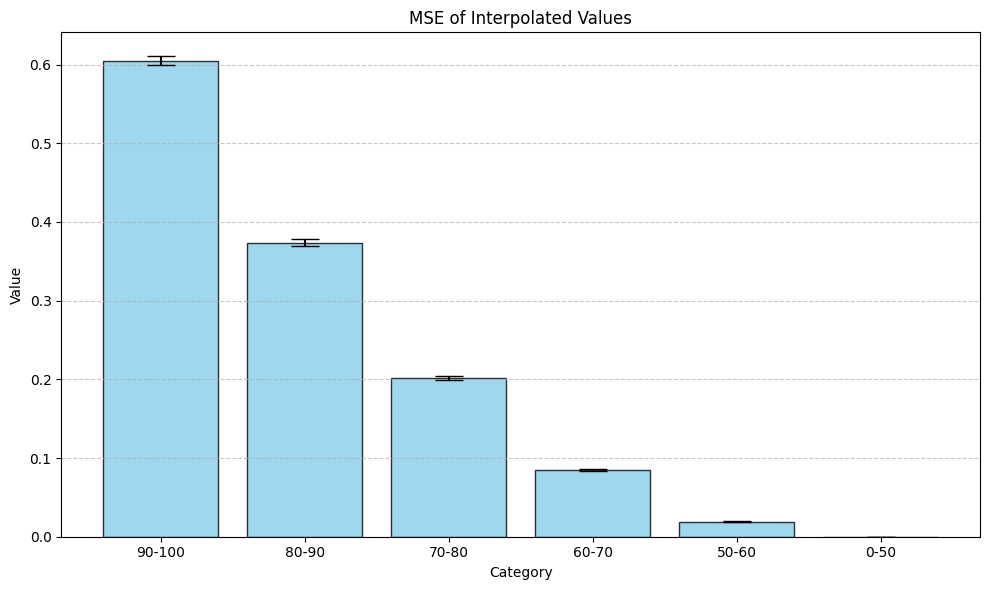

In [119]:
plot_bar_with_std_error(error_dists, title="MSE of Interpolated Values", ylabel="Value", xlabel="Category")


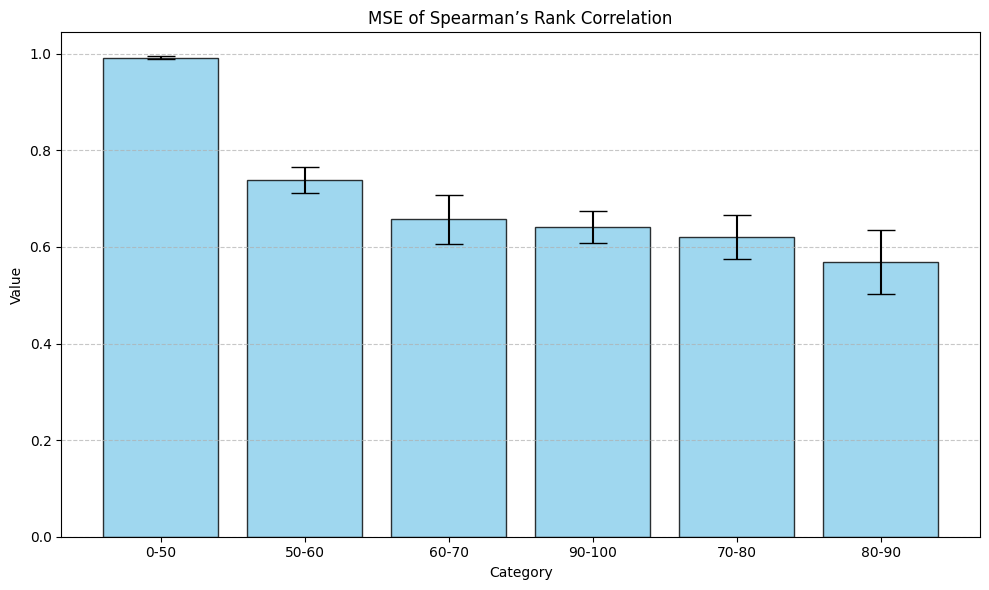

In [111]:
from scipy import stats

def generate_ordered_vals(x0,x1,nsamples):
    interpolated_vals,actual_vals,nbrs,nbr_vals =generate_interpolation_vals(x0,x1,nsamples)
    # interp_sort_indices = np.argsort(interpolated_vals)
    # actual_indices = np.argsort(actual_vals)
    correlation, p_value = stats.spearmanr(interpolated_vals, actual_vals)
    return correlation,p_value


corr_dists={"0-50":[],"50-60":[],"60-70":[],"70-80":[],"80-90":[],"90-100":[]}
for k in error_dists.keys():
    x0,x1=k.split("-")
    for e in range(20):
        correlation, p_value = generate_ordered_vals(float(x0),float(x1),10)
        corr_dists[k].append(correlation)

plot_bar_with_std_error(corr_dists, title="MSE of Spearman’s Rank Correlation", ylabel="Value", xlabel="Category")

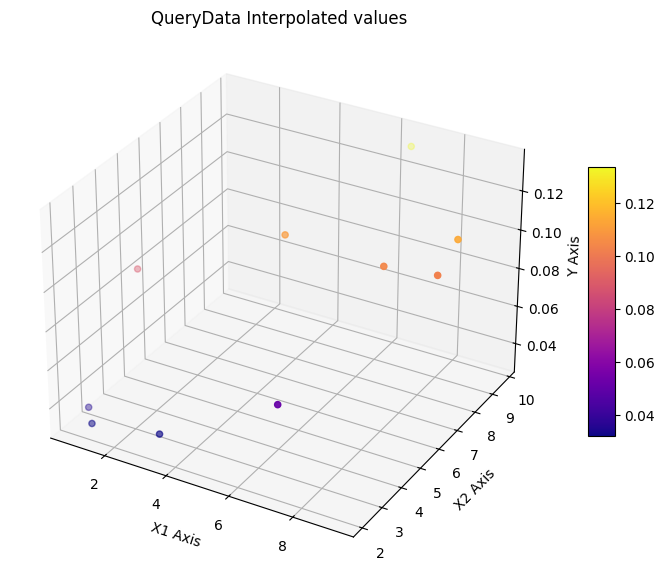

(10000, 2)


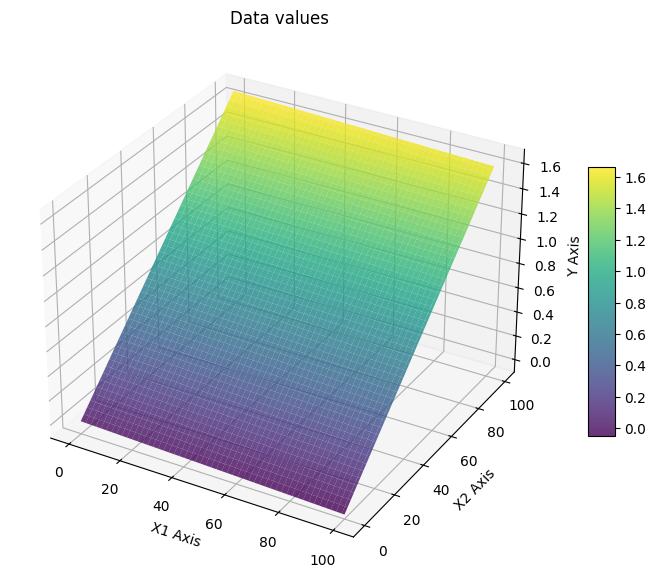

In [89]:
grid_x = np.linspace(0, 100, 100)
grid_y = np.linspace(0, 100, 100)
X1_surf, X2_surf = np.meshgrid(grid_x, grid_y)
coords = []
for i in range(100):
    for j in range(100):
        coords.append([X1_surf[i][j],X2_surf[i][j]])
coords = np.array(coords).astype("float32")
Y_surf = rd_net(torch.tensor(coords)).detach().numpy().reshape([100,100])
plot_3d_data(X1_surf, X2_surf, Y_surf, title="Data values", plot_type='surface')

In [120]:
REG_PARAM=10**-9
def updateVals(index,x,radius,vals,n_neighbors,alpha):
    n = x.shape[0]
    lims, distances, indices = index.range_search(x, radius)
    for i in range(n):
        ind = [indices[lims[i]:lims[i + 1]]]
        dists = [distances[lims[i]:lims[i + 1]]]

        for ind_item, dist_item in zip(ind, dists):
            if len(ind_item) >= n_neighbors:
                dist_weights = (1 / (np.array(dist_item) + REG_PARAM)) / np.sum(
                    (1 / (np.array(dist_item) + REG_PARAM)))
                for j, idx in enumerate(ind_item):
                    vals[idx] += alpha*dist_weights[j] * (
                            vals[i] - vals[idx])
